In [1]:
import os
import sys
import csv
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src.core.utils.constants import EPSILON
from src.core.utils import data_analysis, context_manager
from src.architectures.auto_regressive import SequentialAutoRegressive
from src import Tensor, layers, loss_functions, optimizers, metrics, callbacks

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'stock_prediction_lstm')
dataset_path = os.path.join(os.getcwd(), 'dataset', 'SPX.csv')

# Define the feature and target columns
feature_columns = ['Open', 'High', 'Low', 'Close']
close_price_idx = feature_columns.index('Close')

In [3]:
# Define a temporal split for the dataset
train_end_date = '2010-12-31'
valid_end_date = '2016-12-31'

# Hyperparameters for the model
learning_rate = 1e-4
batch_size = 64
epochs = 50
seq_len = 48
seed = 1234

# Volatility prediction settings
predict_volatility = True
volatility_window = 5

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
def load_data(file_path: str) -> list[dict]:
    """
    Load data from a CSV file with proper date parsing.
    
    Parameters:
    - file_path: str, path to the CSV file
    
    Returns:
    - data: list[dict], list of dictionaries containing the data
    """
    
    # Create a list to hold the data
    data = []
    
    # Open the CSV file and read its contents
    with open(file_path, 'r') as file:
        # Use DictReader to read the CSV file into a list of dictionaries
        reader = csv.DictReader(file)
        
        # Iterate over each row in the CSV file
        for row in reader:
            # Ensure the 'Date' field is in the correct format
            try:
                # Parse the date and convert it to a datetime object
                datetime.strptime(row['Date'], '%Y-%m-%d')
                
                # Add the row to the data list
                data.append(row)
                
            except ValueError:
                # If the date is invalid, skip this row
                print(f"Skipping row with invalid date: {row['Date']}")
                continue
    
    # Sort the data by date
    data.sort(key=lambda x: x['Date'])
    
    # return the loaded and sorted data
    return data

In [6]:
# Load the data
data = load_data(dataset_path)

# Print the number of data points and the date range
print(f"Loaded {len(data)} data points")
print(f"Date range: {data[0]['Date']} to {data[-1]['Date']}")

Loaded 23323 data points
Date range: 1927-12-30 to 2020-11-04


In [7]:
# Extract the feature and date columns
features = np.array([[np.float32(data[j][k]) for k in feature_columns] for j in range(len(data))])
dates = np.array([data[j]['Date'] for j in range(len(data))])

# Print the shapes of the features and dates arrays
print(f"Price data shape: {features.shape}")
print(f"Dates shape: {dates.shape}")

Price data shape: (23323, 4)
Dates shape: (23323,)


### Features engineering

In [8]:
def compute_log_returns(prices: np.ndarray) -> np.ndarray:
    """
    Calculate log returns: ln(P_t / P_{t-1})
    
    Parameters:
    - prices: np.ndarray, absolute prices with shape (T, F)
    
    Returns:
    - log_returns: np.ndarray, log returns with shape (T-1, F)
    """
    
    # Compute log returns using the formula ln(P_t / P_{t-1})
    return np.log(prices[1:] / prices[:-1])


def compute_realized_volatility(log_returns: np.ndarray, window: int) -> np.ndarray:
    """
    Calculate realized volatility using rolling window of squared returns.
    
    Parameters:
    - log_returns: np.ndarray, log returns with shape (T, F)
    - window: int, rolling window size
    
    Returns:
    - volatility: np.ndarray, realized volatility
    """
    
    # Compute squared log returns
    squared_returns = log_returns ** 2
    
    # Initialize an empty list to hold the volatility values
    volatility = []
    
    # Iterate over the log returns with a rolling window
    for i in range(window, len(squared_returns)):
        # Calculate the volatility as the square root of the mean of squared returns
        vol = np.sqrt(np.mean(squared_returns[i-window:i], axis=0))
        
        # Append the calculated volatility to the list
        volatility.append(vol)
    
    # Convert the list to a numpy array and return
    return np.array(volatility)

In [9]:

# Compute log returns
log_returns = compute_log_returns(features)
dates_returns = dates[1:]

# Print the shape and statistics of the log returns
print(f"Log returns shape: {log_returns.shape}")
print(f"Log returns stats - Mean: {np.mean(log_returns, axis=0)}")
print(f"Log returns stats - Std: {np.std(log_returns, axis=0)}")

# Compute realized volatility if required
if predict_volatility:
    # Compute realized volatility using a rolling window
    realized_volatility = compute_realized_volatility(log_returns, volatility_window)
    
    # Adjust dates for the volatility data
    dates_volatility = dates_returns[volatility_window:]
    
    # Print the shape and statistics of the realized volatility
    print(f"Realized volatility shape: {realized_volatility.shape}")

Log returns shape: (23322, 4)
Log returns stats - Mean: [0.00022563 0.00022662 0.00022561 0.00022609]
Log returns stats - Std: [0.01179839 0.01105997 0.01168979 0.01202147]
Realized volatility shape: (23317, 4)


### Data preprocessing

In [10]:
# Set the target data based on whether we are predicting volatility or log returns
if predict_volatility:
    # Use realized volatility as target data
    target_data = realized_volatility
    target_dates = dates_volatility
    input_data = log_returns[volatility_window:] 
    input_dates = dates_volatility
    print("Predicting realized volatility")
else:
    # Use log returns as target data
    target_data = log_returns
    target_dates = dates_returns
    input_data = log_returns
    input_dates = dates_returns
    print("Predicting log returns")

# Perform the temporal split
print(f"Target data shape: {target_data.shape}")
print(f"Input data shape: {input_data.shape}")

Predicting realized volatility
Target data shape: (23317, 4)
Input data shape: (23317, 4)


In [11]:
def build_sequences_correct(input_data: np.ndarray, target_data: np.ndarray, seq_length: int) -> tuple[Tensor, Tensor]:
    """
    Build sequences
    
    Parameters:
    - input_data: np.ndarray, input features
    - target_data: np.ndarray, target values (aligned with input_data)
    - seq_length: int, length of input sequences
    
    Returns:
    - tuple[Tensor, Tensor], input sequences and targets
    """
    
    # Initialize lists to hold sequences and targets
    X, y = [], []
    
    # Iterate over the input data to create sequences
    for i in range(seq_length, len(input_data)):
        # Append the sequence of input and the corresponding target
        X.append(input_data[i-seq_length:i])
        y.append(target_data[i])
    
    # Convert the lists to numpy arrays and return as Tensors
    return Tensor(np.array(X, dtype=np.float32)), Tensor(np.array(y, dtype=np.float32))

In [12]:
# Build sequences
features, targets = build_sequences_correct(input_data, target_data, seq_len)

# Print the shapes of the features and targets
print(f"Features shape: {features.shape()}")
print(f"Targets shape: {targets.shape()}")

Features shape: (23269, 48, 4)
Targets shape: (23269, 4)


### Data splitting

In [13]:
def temporal_split(data: np.ndarray, dates: np.ndarray, train_end: str, valid_end: str):
    """
    Split data temporally based on dates.
    
    Parameters:
    - data: np.ndarray, input data
    - dates: np.ndarray, corresponding dates
    - train_end: str, end date for training set
    - valid_end: str, end date for validation set
    
    Returns:
    - tuple of train, valid, test splits
    """
    
    # Create a mask for each split based on the dates
    train_mask = dates <= train_end
    valid_mask = (dates > train_end) & (dates <= valid_end)
    test_mask = dates > valid_end
    
    # Apply the masks to the data
    train_data = data[train_mask]
    valid_data = data[valid_mask]
    test_data = data[test_mask]
    
    # Return the splits along with their masks
    return train_data, valid_data, test_data, train_mask, valid_mask, test_mask

In [14]:
# Convert to numpy arrays for further processing
features_np = features.to_numpy()
targets_np = targets.to_numpy()
sequence_dates = input_dates[seq_len:]

# Temporal split the data into training, validation, and test sets
train_features, valid_features, test_features, train_mask, valid_mask, test_mask = temporal_split(
    data = features_np, 
    dates = sequence_dates, 
    train_end = train_end_date, 
    valid_end = valid_end_date
)

# Temporal split the targets into training, validation, and test sets
train_targets, valid_targets, test_targets, _, _, _ = temporal_split(
    data = targets_np, 
    dates = sequence_dates, 
    train_end = train_end_date, 
    valid_end = valid_end_date
)

# Convert the splits to Tensors
X_train = Tensor(train_features)
X_valid = Tensor(valid_features)
X_test = Tensor(test_features)
y_train = Tensor(train_targets)
y_valid = Tensor(valid_targets)
y_test = Tensor(test_targets)

# Print the shapes of the training, validation, and test sets
print(f"\nTraining set: {X_train.shape()}, {y_train.shape()}")
print(f"Validation set: {X_valid.shape()}, {y_valid.shape()}")
print(f"Test set: {X_test.shape()}, {y_test.shape()}")


Training set: (20791, 48, 4), (20791, 4)
Validation set: (1510, 48, 4), (1510, 4)
Test set: (968, 48, 4), (968, 4)


### Data normalization

In [ ]:
def compute_normalization_stats(X_train: Tensor) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    """
    Compute normalization statistics from training data only.
    
    Parameters:
    - X_train: Tensor, training data
    
    Returns:
    - tuple[Tensor, Tensor, Tensor, Tensor], mean, std, min, max
    """
    
    # Extract the data from the Tensor
    data = X_train.to_numpy()
    
    # Compute mean, std, min, and max across the first two axes (time and features)
    min = np.min(data, axis=(0, 1))
    max = np.max(data, axis=(0, 1))
    mean = np.mean(data, axis=(0, 1))
    std = np.std(data, axis=(0, 1))
    
    # Ensure std is not zero to avoid division by zero
    std = np.maximum(std, EPSILON)
    
    # Return as Tensors
    return Tensor(mean), Tensor(std), Tensor(min), Tensor(max)

def z_score_normalize(X: Tensor, mean: Tensor, std: Tensor) -> Tensor:
    """
    Z-score normalization
    
    Parameters:
    - X: Tensor, input data to normalize
    - mean: Tensor, mean for normalization
    - std: Tensor, standard deviation for normalization
    
    Returns:
    - Tensor, normalized data
    """
    
    # Compute Z-score normalization
    return (X - mean) / std

def z_score_denormalize(X: Tensor, mean: Tensor, std: Tensor) -> Tensor:
    """
    Z-score denormalization
    
    Parameters:
    - X: Tensor, normalized data to denormalize
    - mean: Tensor, mean used for normalization
    - std: Tensor, standard deviation used for normalization
    
    Returns:
    - Tensor, denormalized data
    """
    
    # Compute denormalization
    return X * std + mean

def min_max_normalize(X: Tensor, min: Tensor, max: Tensor) -> Tensor:
    """
    Min-Max normalization
    
    Parameters:
    - X: Tensor, input data to normalize
    - min: Tensor, minimum for normalization
    - max: Tensor, maximum for normalization
    
    Returns:
    - Tensor, normalized data
    """
    
    # Compute Min-Max normalization
    return (X - min) / (max - min + EPSILON)

def min_max_denormalize(X: Tensor, min: Tensor, max: Tensor) -> Tensor:
    """
    Min-Max denormalization
    
    Parameters:
    - X: Tensor, normalized data to denormalize
    - min: Tensor, minimum used for normalization
    - max: Tensor, maximum used for normalization
    
    Returns:
    - Tensor, denormalized data
    """
    
    # Compute denormalization
    return X * (max - min) + min

In [ ]:
# Compute normalization statistics from training data only
mean, std, min, max = compute_normalization_stats(X_train)

# Print the normalization statistics
print('Normalization statistics (from training data only):')
print('Mean:', mean.to_numpy())
print('Std:', std.to_numpy())

# Normalize the training, validation, and test sets using training statistics
X_train_norm = z_score_normalize(X_train, mean, std)
X_valid_norm = z_score_normalize(X_valid, mean, std)
X_test_norm = z_score_normalize(X_test, mean, std)

# Compute the normalization statistics for the target variable (y)
target_mean, target_std, target_min, target_max = compute_normalization_stats(y_train.unsqueeze(1))

# Normalize the target variable using the computed statistics
y_train_norm = z_score_normalize(y_train, target_mean, target_std)
y_valid_norm = z_score_normalize(y_valid, target_mean, target_std)

# Print the normalization statistics for the target variable
print('\nTarget normalization stats:')
print('Target Mean:', target_mean.to_numpy())
print('Target Std:', target_std.to_numpy())

Normalization statistics (from training data only):
Mean: [0.00020396 0.00020415 0.00020373 0.00020401]
Std: [0.01203457 0.01135624 0.01191499 0.01213149]

Target normalization stats:
Target Mean: [0.00934289 0.00878319 0.00915235 0.00940592]
Target Std: [0.00759923 0.00721141 0.00764178 0.00767581]


### Building the model

In [17]:
# Define the model architecture
model = SequentialAutoRegressive(
    name = "Stock prediction model",
    sequence_length = seq_len,
    modules = [
        layers.LSTM(num_layers=2, num_units=64, dropout=0.3),
        layers.Dense(num_units=32),
        layers.Dropout(0.3),
        layers.Dense(num_units=y_train.shape()[-1])
    ]
)

# Initialize the optimizer with lower learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.MeanSquareError()

### Initializing the model

In [18]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    model(X_train_norm[:batch_size])

In [19]:
# Display model summary
model.summary(recursive=True)

Stock prediction model (SequentialAutoRegressive) [output_shape=(64, 4), params=53412]
└── stock_prediction_model.modules (ModuleList) [output_shape=(64, 4), params=53412]
    ├── module_list.0 (LSTM) [output_shape=(64, 64), params=51200]
    │   └── lstm.dropout_layer (Dropout) [output_shape=(64, 64), params=0]
    ├── module_list.1 (Dense) [output_shape=(64, 32), params=2080]
    ├── module_list.2 (Dropout) [output_shape=(64, 32), params=0]
    └── module_list.3 (Dense) [output_shape=(64, 4), params=132]


### Training the model

In [20]:
# Training with early stopping
history = model.fit(
    X_train = X_train_norm,
    y_train = y_train_norm,
    X_valid = X_valid_norm,
    y_valid = y_valid_norm,
    epochs = epochs,
    loss_fn = loss_fn,
    optimizer = optimizer,
    batch_size = batch_size,
    metrics = [metrics.mean_absolute_error],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=1e-6)]
)

Epoch 1/50 --> loss: 0.62669 - mean absolute error: 0.44605 | Valid loss: 0.12926 - Valid mean absolute error: 0.25801             
Epoch 2/50 --> loss: 0.24226 - mean absolute error: 0.27336 | Valid loss: 0.077405 - Valid mean absolute error: 0.19601             
Epoch 3/50 --> loss: 0.15659 - mean absolute error: 0.22808 | Valid loss: 0.067251 - Valid mean absolute error: 0.18166             
Epoch 4/50 --> loss: 0.13926 - mean absolute error: 0.22104 | Valid loss: 0.06193 - Valid mean absolute error: 0.1769              
Epoch 5/50 --> loss: 0.13193 - mean absolute error: 0.21395 | Valid loss: 0.059142 - Valid mean absolute error: 0.17244             
Epoch 6/50 --> loss: 0.12143 - mean absolute error: 0.20777 | Valid loss: 0.058983 - Valid mean absolute error: 0.17383             
Epoch 7/50 --> loss: 0.11182 - mean absolute error: 0.20211 | Valid loss: 0.056172 - Valid mean absolute error: 0.16618             
Epoch 8/50 --> loss: 0.10558 - mean absolute error: 0.19843 | Valid los

In [21]:
# Save the model
model.save(model_path)

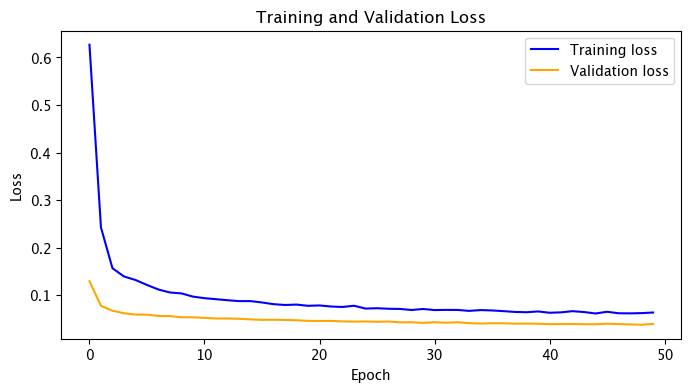

In [22]:
# Plot training history
data_analysis.plot_history(
    train_loss = model.history["loss"], 
    valid_loss = model.history["val_loss"],
    title = "Training and Validation Loss",
    xlabel = "Epoch",
    ylabel = "Loss"
)

### Evaluation

In [23]:
# Disable gradient computation for evaluation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions_norm = model(X_test_norm)

In [24]:
def directional_accuracy(pred: Tensor, true: Tensor) -> float:
    """
    Compute the directional accuracy of predictions.
    
    Parameters:
    - pred: Tensor, predicted values
    - true: Tensor, true values
    
    Returns:
    - float, directional accuracy
    """
    
    # If predicting volatility, check if it increases or decreases
    if predict_volatility:
        # Check if the predicted and true values are increasing or decreasing
        pred_direction = (pred.to_numpy()[1:] > pred.to_numpy()[:-1]).astype(int)
        true_direction = (true.to_numpy()[1:] > true.to_numpy()[:-1]).astype(int)
    else:
        # For log returns, check if the predicted and true values are positive or negative
        pred_direction = (pred.to_numpy() > 0).astype(int)
        true_direction = (true.to_numpy() > 0).astype(int)
    
    # Calculate the directional accuracy
    accuracy = np.mean(pred_direction == true_direction)
    
    # Return the directional accuracy
    return accuracy

In [25]:
# Denormalize the predictions using the target normalization statistics
predictions = z_score_denormalize(predictions_norm, target_mean, target_std)

# Compute the mean absolute error on the test set
mae = metrics.mean_absolute_error(predictions, y_test)

# Print the test results
print(f"Test Results:")
print(f"Mean Absolute Error: {mae.to_numpy()}")

# Compute the directional accuracy
dir_acc = directional_accuracy(predictions, y_test)

# Print the directional accuracy
print(f"Directional Accuracy: {dir_acc:.3f}")

Test Results:
Mean Absolute Error: 0.0013347158674150705
Directional Accuracy: 0.717


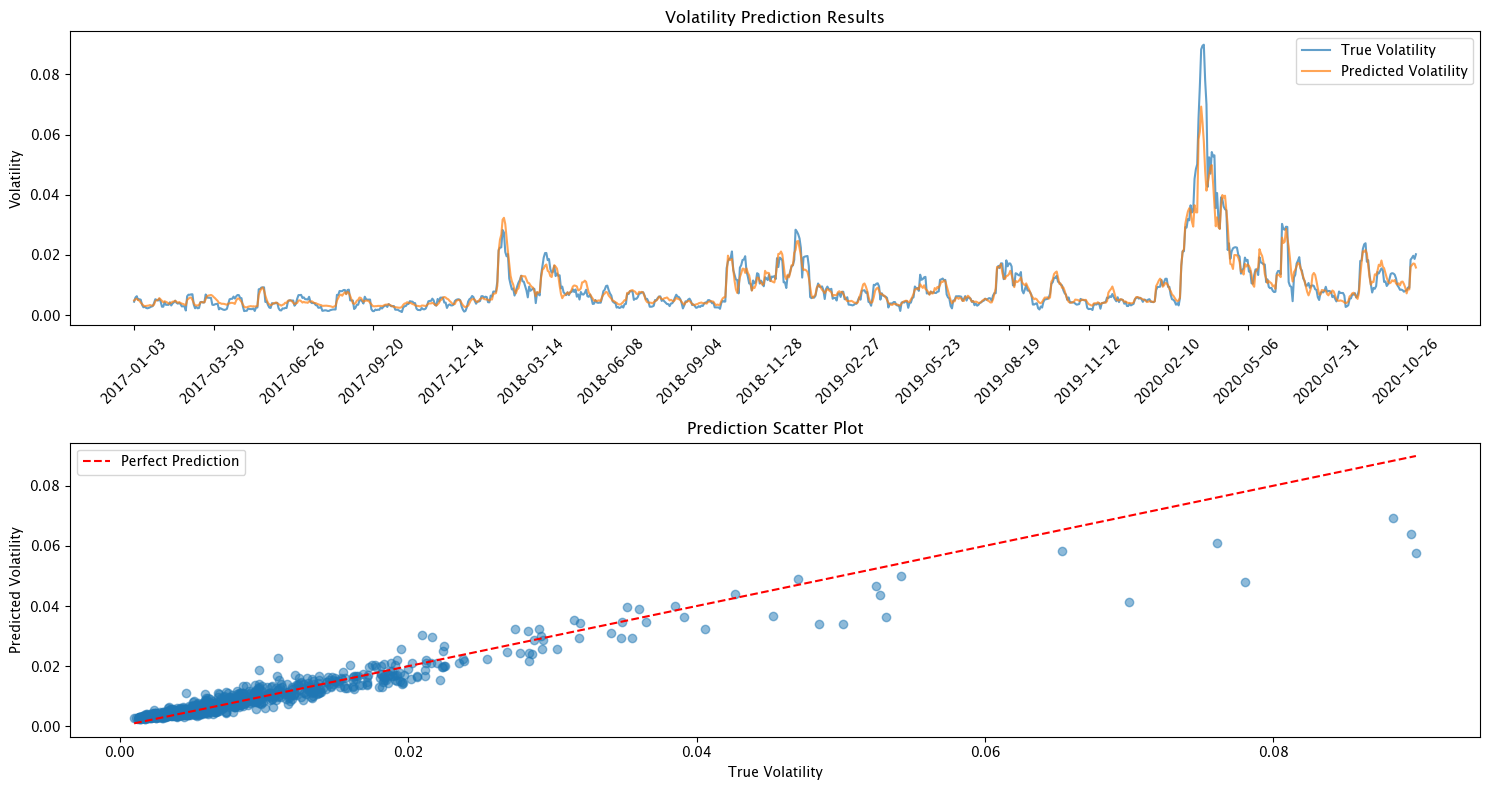

In [26]:
# Create a figure for plotting
plt.figure(figsize=(15, 8))

# Plot the predictions and true values
if predict_volatility:
    # For volatility, plot the time series and scatter plot
    test_dates = sequence_dates[test_mask]
    
    # Plot the time series of true and predicted volatility
    plt.subplot(2, 1, 1)
    plt.plot(test_dates[:len(y_test.to_numpy())], y_test.to_numpy()[:, close_price_idx], label='True Volatility', alpha=0.7)
    plt.plot(test_dates[:len(predictions.to_numpy())], predictions.to_numpy()[:, close_price_idx], label='Predicted Volatility', alpha=0.7)
    plt.title('Volatility Prediction Results')
    plt.ylabel('Volatility')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
    plt.xticks(rotation=45)
    
    # Scatter plot of true vs predicted volatility
    plt.subplot(2, 1, 2)
    plt.scatter(y_test.to_numpy()[:, close_price_idx], predictions.to_numpy()[:, close_price_idx], alpha=0.5)
    plt.plot(
        [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()],
        [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()],
        'r--', label='Perfect Prediction'
    )
    plt.xlabel('True Volatility')
    plt.ylabel('Predicted Volatility')
    plt.title('Prediction Scatter Plot')
    plt.legend()
    
else:
    # For log returns, plot the time series and scatter plot
    test_dates = sequence_dates[test_mask]
    
    # Plot the time series of true and predicted log returns
    plt.subplot(2, 1, 1)
    plt.plot(test_dates[:len(y_test.to_numpy())], y_test.to_numpy()[:, close_price_idx], label='True Log Returns', alpha=0.7)
    plt.plot(test_dates[:len(predictions.to_numpy())], predictions.to_numpy()[:, close_price_idx], label='Predicted Log Returns', alpha=0.7)
    plt.title('Log Returns Prediction Results')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
    plt.xticks(rotation=45)
    
    # Scatter plot of true vs predicted log returns
    plt.subplot(2, 1, 2)
    plt.scatter(y_test.to_numpy()[:, close_price_idx], predictions.to_numpy()[:, close_price_idx], alpha=0.5)
    plt.plot(
        [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()], 
        [y_test.to_numpy()[:, close_price_idx].min(), y_test.to_numpy()[:, close_price_idx].max()], 
        'r--', label='Perfect Prediction'
    )
    plt.xlabel('True Log Returns')
    plt.ylabel('Predicted Log Returns')
    plt.title('Prediction Scatter Plot')
    plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Inference

In [27]:
# Create function to denormalize input data
def denormalize_fn(x):
    return z_score_denormalize(x, target_mean, target_std)

In [28]:
# Define the number of generation steps
num_generation_steps = 8

# Select the middle index for the test set
test_idx = len(X_test_norm.to_numpy()) // 2 

# Take the initial sequence and true continuation for evaluation
initial_seq = X_test_norm[test_idx:test_idx+1]
true_continuation = y_test[test_idx:test_idx+num_generation_steps]

# Perform autoregressive prediction
out_seq = model.autoregressive_generation(
    x = initial_seq,
    num_steps = num_generation_steps,
    denormalize_fn = denormalize_fn
)

# Extract the generated sequence if out_seq is a generator
generated_sequence = model.concat_generation(out_seq) if not isinstance(out_seq, Tensor) else out_seq

# Extract the first batch of the generated sequence
generated_sequence = generated_sequence[0]

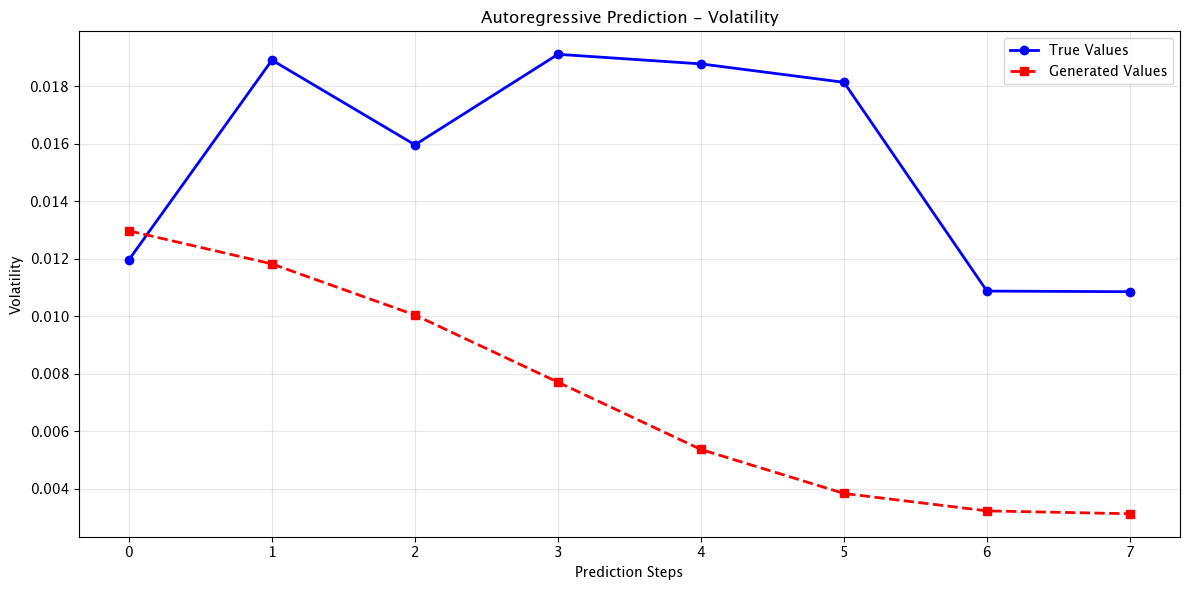

In [29]:
# Plot autoregressive results
plt.figure(figsize=(12, 6))

# Define the steps for plotting
steps = range(num_generation_steps)
feature_idx = close_price_idx

# Plot the true continuation and generated sequence
plt.plot(steps, true_continuation.to_numpy()[:num_generation_steps, close_price_idx], 'b-', label='True Values', linewidth=2, marker='o')
plt.plot(steps, generated_sequence.to_numpy()[:, close_price_idx], 'r--', label='Generated Values', linewidth=2, marker='s')

# Define the plot configurations
plt.title(f'Autoregressive Prediction - {"Volatility" if predict_volatility else "Log Returns"}')
plt.xlabel('Prediction Steps')
plt.ylabel(f'{"Volatility" if predict_volatility else "Log Returns"}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Compute the autoregressive directional accuracy
auto_dir_acc = directional_accuracy(generated_sequence[:, close_price_idx], true_continuation[:, close_price_idx])

# Print the autoregressive directional accuracy
print(f"Autoregressive Directional Accuracy: {auto_dir_acc:.3f}")

Autoregressive Directional Accuracy: 0.714
